In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import six
sys.path.append("/Users/admin/Desktop/projects/lb_time/utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
import function
import preprocessing
import local_bayes
import visualize
import metrics
import analysis

In [4]:
sys.path.append("/Users/admin/Desktop/projects/lb_time/models/cnn")
import train

# data load

In [5]:
save_data_dir = '../data/bookmark/'
train_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_train.npz')
test_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_test.npz')

# learner analysis

In [20]:
localbayes = local_bayes.LocalBayes()
analyze = analysis.Analysis()
visual = visualize.Visualize()

## Gradient Boosting Decision Tree

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### model fit

In [8]:
max_depth = 4
n_estimators = 5000

In [9]:
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
#                          algorithm="SAMME",
#                          n_estimators=5000)

In [10]:
# bdt.fit(train_0_0['x'], train_0_0['y'])

In [11]:
# joblib.dump(bdt, '../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators)) 

### model load

In [12]:
bdt = joblib.load('../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators))

#### sample prediction

In [13]:
pred_proba = bdt.predict_proba(test_0_0['x'])
pred_proba[0:10]

array([[ 0.50418546,  0.49581454],
       [ 0.50714813,  0.49285187],
       [ 0.49450888,  0.50549112],
       [ 0.49821045,  0.50178955],
       [ 0.49816166,  0.50183834],
       [ 0.49889502,  0.50110498],
       [ 0.49458565,  0.50541435],
       [ 0.52426302,  0.47573698],
       [ 0.49845624,  0.50154376],
       [ 0.53994096,  0.46005904]])

#### answer

In [14]:
test_0_0['y'][0:10]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

### miss pattern

In [16]:
miss_x, miss_y = analyze.find_pattern(test_0_0, pred_proba)

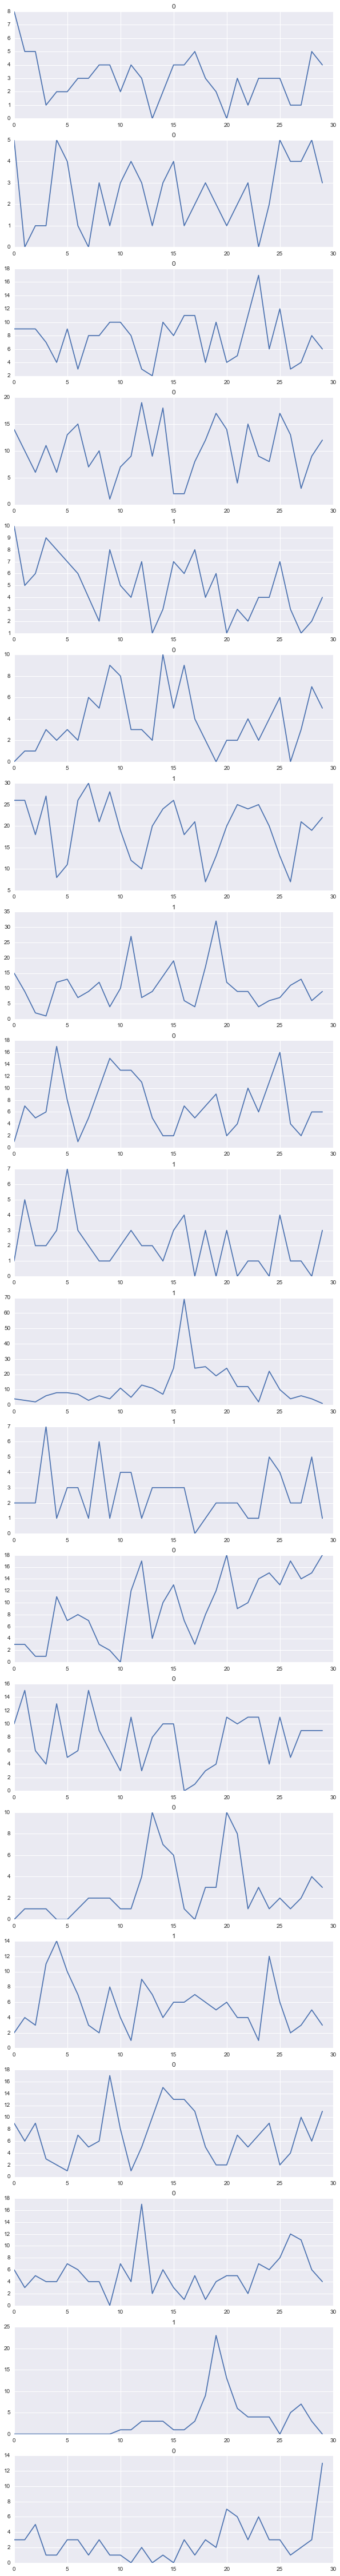

In [17]:
plt.figure(figsize=(10, 4*20), dpi=1000)
for i in xrange(20):
    plt.subplot(20, 1, i + 1)
    plt.plot(miss_x[i])
    plt.title('%s' % miss_y[i])

### correct pattern

In [18]:
correct_x, correct_y = analyze.find_pattern(test_0_0, pred_proba, type="correct")

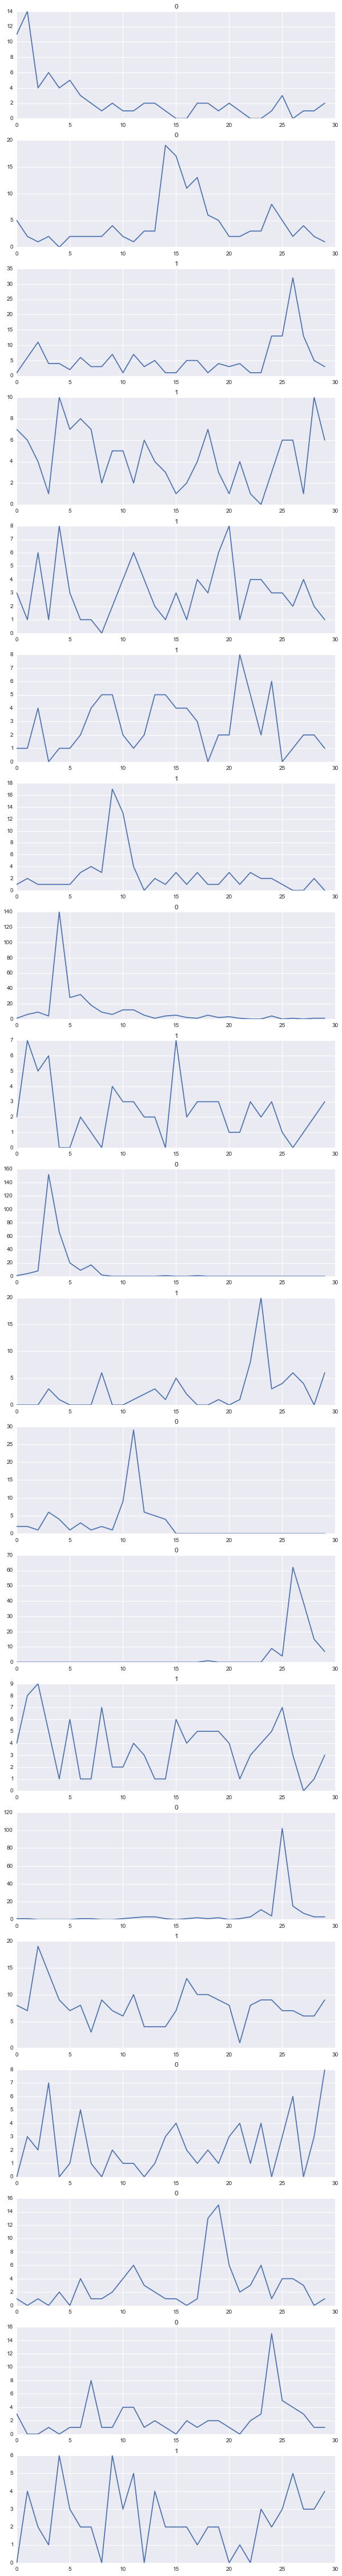

In [19]:
plt.figure(figsize=(10, 4*20), dpi=1000)
for i in xrange(20):
    plt.subplot(20, 1, i + 1)
    plt.plot(correct_x[i])
    plt.title('%s' % correct_y[i])

### ROC curve and AUC

In [21]:
test_score = bdt.decision_function(test_0_0['x'])

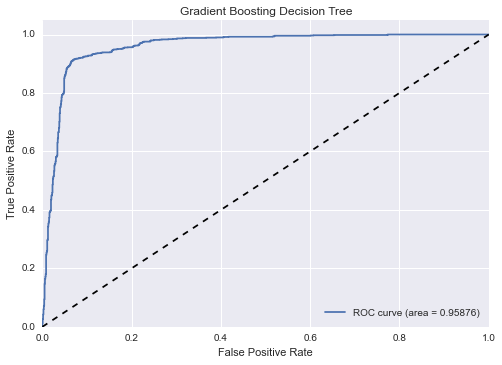

In [22]:
visual.roc_curve('Gradient Boosting Decision Tree', test_0_0, test_score)

## CNN

In [23]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [34]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [35]:
sys.path.append("/Users/admin/Desktop/projects/lb_time/models/cnn")
import net

## model load

In [36]:
cnnnet = net.tsCNN_net(30)

In [33]:
model = L.Classifier(cnnnet)

In [38]:
serializers.load_npz(save_model_dir + "mlp.model", model)

## prediction

In [39]:
N_test = test_0_0['x'].shape[0]
data_dim = test_0_0['x'].shape[1]

In [40]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [41]:
test_0_0['x'].shape

(2378, 30)

In [42]:
X_test = test_0_0['x'].reshape((N_test, 1, 1, data_dim))
y_test = test_0_0['y']
pred_ = []
for i in range(0, N_test):
    x = np.asarray(X_test[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    y = np.asarray(y_test[i]).astype(numpy.int32)
    
    pred = F.softmax(model.predictor(chainer.Variable(x)))
    pred_.append(pred.data[0][1])

#### sample prediction

In [43]:
pred_[0:10]

[7.440859e-08,
 1.9538052e-07,
 1.0,
 0.99544889,
 0.99741024,
 0.89813262,
 0.99999499,
 0.0,
 0.99734312,
 0.0]

#### sample answer

In [44]:
y_test[0:10]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

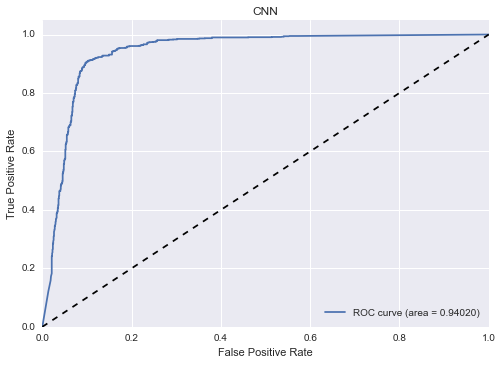

In [46]:
visual.roc_curve('CNN', test_0_0, numpy.array(pred_))